In [29]:
import numpy as np
import sympy as sym
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
def construct_frequency_matrix(path_to_pairwise_counts_unbound : str, path_to_pairwise_counts_bound : str):
    """Constructs the frequency matrix from the pairwise count files output by the dmMIME simulator.
    First the bound and unbound counts are added together to get the total counts of the initial pool.
    Then a square n x n matrix is constructed where n is the number of possible mutations, so sequence length * 3.
    For mutations at the same position the entry is 0, which are 3x3 blocks along the diagonal.
    For the mutation of interest the entry is 1, which is 1 along the diagonal.
    For mutations at different positions the entry is the pairwise frequency of both mutations - the pairwise frequency of the mutation and the wildtype.


    Args:
        path_to_pairwise_counts_unbound (str): path to the pairwise count file for unbound sequences output by the dmMIME simulator (8.txt)
        path_to_pairwise_counts_bound (str): path to the pairwise count file for bound sequences output by the dmMIME simulator (7.txt)
    """

    unbound_counts = np.loadtxt(path_to_pairwise_counts_unbound, skiprows=1, delimiter='\t')
    bound_counts = np.loadtxt(path_to_pairwise_counts_bound, skiprows=1, delimiter='\t')

    # first 2 columns for positions stay the same, the rest are the counts
    counts = np.hstack((unbound_counts[:, :2], unbound_counts[:, 2:] + bound_counts[:, 2:]))

    # construct the frequency matrix
    n_pos = np.where(counts[:, 0] == 1)[0].shape[0] + 1
    n_mut =  n_pos * 3
    freq_matrix = np.zeros((n_mut, n_mut))

    for pos1 in range(n_pos):
        for pos2 in range(n_pos):
            if pos1 == pos2:
                for mut1 in range(3):
                    for mut2 in range(3):
                    # if mutations are at the same position
                        if mut1 == mut2:
                            freq_matrix[pos1*3 + mut1, pos2*3 + mut2] = 1
                        else:
                            freq_matrix[pos1*3 + mut1, pos2*3 + mut2] = 0

            else:
                for mut1 in range(3):
                    for mut2 in range(3):
                        # TODO this part still needs correction of the counts for sequencing errors
                        if pos1 < pos2:
                            pairwise_counts = counts[np.where((counts[:, 0] == pos1 + 1) & (counts[:, 1] == pos2 + 1))[0], 2:]
                            # get pairwise frequency of the mutation 2 at position 2 and the wildtype at position 1
                            freq_mut2_wt1 = pairwise_counts[0, mut2+1]/(pairwise_counts[0, 0] + pairwise_counts[0, 1] + pairwise_counts[0, 2] + pairwise_counts[0, 3])
                            # get pairwise frequency of the mutation 2 at position 2 and the mutation 1 at position 1
                            freq_mut2_mut1 = pairwise_counts[0, (mut1+1)*4 + mut2+1]/(pairwise_counts[0, (mut1+1)*4] + pairwise_counts[0, (mut1+1)*4 + 1] + pairwise_counts[0, (mut1+1)*4 + 2] + pairwise_counts[0, (mut1+1)*4 + 3])

                            freq_matrix[pos1*3 + mut1, pos2*3 + mut2] = freq_mut2_mut1 - freq_mut2_wt1

                        if pos1 > pos2:
                            pairwise_counts = counts[np.where((counts[:, 0] == pos2 + 1) & (counts[:, 1] == pos1 + 1))[0], 2:]
                            # get pairwise frequency of the mutation 2 at position 2 and the wildtype at position 1
                            freq_mut2_wt1 = pairwise_counts[0, (mut2+1)*4]/(pairwise_counts[0, 0] + pairwise_counts[0, 4] + pairwise_counts[0, 8] + pairwise_counts[0, 12])
                            # get pairwise frequency of the mutation 2 at position 2 and the mutation 1 at position 1
                            freq_mut2_mut1 = pairwise_counts[0, (mut2+1)*4 + mut1+1]/(pairwise_counts[0, (mut2+1)*4] + pairwise_counts[0, (mut2+1)*4 + 1] + pairwise_counts[0, (mut2+1)*4 + 2] + pairwise_counts[0, (mut2+1)*4 + 3])

                            freq_matrix[pos1*3 + mut1, pos2*3 + mut2] = freq_mut2_mut1 - freq_mut2_wt1

    print(freq_matrix.shape)
    print(np.round(freq_matrix[:12, :12], 2))

    return freq_matrix


In [31]:
path_to_data = '/home/user/data_directory/MIME_sim_data/no_epistasis/secondFromProt1/prot1'
A = construct_frequency_matrix(path_to_data + '/2d/8.txt', path_to_data + '/2d/7.txt')

(300, 300)
[[ 1.    0.    0.    0.03  0.03  0.03  0.    0.    0.    0.   -0.    0.  ]
 [ 0.    1.    0.    0.16  0.04  0.06  0.    0.01  0.01  0.   -0.    0.  ]
 [ 0.    0.    1.    0.29  0.19  0.08  0.    0.01  0.01  0.   -0.    0.01]
 [ 0.03  0.17  0.3   1.    0.    0.    0.01  0.04  0.    0.   -0.    0.  ]
 [ 0.02  0.04  0.2   0.    1.    0.    0.01  0.02  0.05  0.01 -0.    0.01]
 [ 0.03  0.06  0.08  0.    0.    1.    0.45  0.01  0.03  0.    0.    0.01]
 [-0.    0.01  0.01  0.01  0.01  0.46  1.    0.    0.    0.03  0.    0.04]
 [-0.    0.    0.01  0.04  0.02  0.02  0.    1.    0.    0.05  0.01  0.04]
 [-0.    0.    0.01  0.    0.05  0.03  0.    0.    1.    0.49  0.01  0.04]
 [-0.    0.01  0.01  0.    0.01  0.01  0.03  0.06  0.5   1.    0.    0.  ]
 [-0.01 -0.   -0.   -0.01 -0.    0.   -0.    0.01  0.02  0.    1.    0.  ]
 [-0.    0.    0.01 -0.    0.    0.01  0.03  0.05  0.05  0.    0.    1.  ]]


In [32]:
def get_inferred_Kds(path : str):
    """
    Get inferred Kds from PositionWiseKdEstimates.csv file
    """
    df = pd.read_csv(path, sep='\t')
    median_mut_C = df['median mut C'].values
    median_mut_G = df['median mut G'].values
    median_mut_U = df['median mut U'].values
    median_Kds = np.vstack((median_mut_C, median_mut_G, median_mut_U)).T.flatten()
    return median_Kds

In [37]:
# load estimated kds
b = get_inferred_Kds(path_to_data + '/results/PositionWiseKdEstimates.csv')
b = np.log(b)
print('nans: ',np.sum(np.isnan(b)))
print(b.shape)
print(np.round(b, 2))

nans:  1
(300,)
[ 0.29  0.11  0.2   0.03 -0.04  2.1   0.63  0.11  0.36  0.48 -2.11  0.1
 -0.38 -0.04 -0.28  0.04 -0.54 -0.01 -0.06 -0.18  0.09 -0.04 -0.03  0.86
  0.14  0.52  0.02  0.7   0.11  0.21  0.65  0.23  0.39  0.51  0.53   nan
  0.22  0.13 -0.24 -0.1   0.62 -0.01 -0.04 -0.79  0.87  0.99  0.02  0.6
  0.17  0.11  0.16  0.11  0.17 -0.75 -0.73  0.08 -0.1   0.05  0.09  0.4
  0.17 -0.05  0.86  0.25  0.11 -0.11 -1.3   0.16  0.32  0.53  0.99  0.08
  0.08  0.07  0.39  0.04  0.04 -0.01 -0.06 -0.12 -0.8  -0.91 -0.13 -0.06
 -0.26  0.03 -0.01  0.03  0.02  0.07  0.01  0.04 -1.31 -0.03  0.02  0.01
  0.06 -0.79 -0.01 -0.48  1.34  0.51  0.46 -0.1   0.09  0.42 -0.42  0.06
  0.23  0.03  0.05  0.03  0.01  0.04  0.09 -0.32 -0.06 -0.   -0.   -0.03
 -1.28  0.02  0.05 -0.01 -0.25  0.95  0.07 -0.95 -0.56  0.05  0.02  0.09
  0.51 -0.55  0.22 -0.45  1.39  0.96  0.03 -0.01 -0.    0.04  0.1  -0.
 -0.77  0.03 -0.01  0.01 -0.61  0.03  0.78  0.    0.79  0.89  0.13  0.03
  1.17 -0.33 -0.68  1.5   0.54 -0.68  1.

In [38]:
# load ground truth kds
ground_truth = np.loadtxt(path_to_data + '/single_kds.txt')
ground_truth = np.log(ground_truth)
print(ground_truth.shape)
print(np.round(ground_truth, 2))

(300,)
[ 0.36  0.    0.    0.    0.    2.73  0.    0.    0.    0.59 -3.05  0.
  0.   -0.13  0.    0.   -0.86  0.    0.14 -0.35  0.    0.   -0.07  1.09
  0.    0.   -0.32  0.92  0.    0.    0.74  0.    0.    0.69  0.75  3.44
 -0.26  0.   -0.47  0.    0.82  0.   -0.18 -1.14  0.66  1.21  0.    0.83
  0.    0.    0.    0.    0.   -0.95 -0.89  0.   -0.22  0.    0.    0.37
  0.   -0.15  1.07  0.    0.    0.   -2.02  0.   -0.07  0.74  1.27  0.
  0.    0.    0.31  0.    0.    0.   -0.12  0.   -1.06 -1.22 -0.11  0.
 -0.34  0.   -0.04  0.    0.    0.    0.    0.   -1.89  0.    0.    0.
  0.   -1.18  0.   -0.64  1.92  0.72  0.67 -0.16  0.    0.58 -0.63  0.
  0.3   0.    0.    0.    0.    0.    0.   -0.49 -0.17  0.   -0.02  0.
 -1.94  0.    0.    0.   -0.35  1.39  0.   -1.42 -0.86  0.26  0.    0.
  0.72 -0.76  0.38 -0.66  1.99  1.48  0.    0.    0.    0.    0.12  0.
 -1.09  0.    0.    0.   -0.91  0.    1.06  0.    0.93  1.05  0.    0.
  1.51 -0.69 -1.09  2.1   0.68 -0.94  1.66  0.    0.   -0.6  -

In [39]:
b[np.isnan(b)] = ground_truth[np.isnan(b)]
print(np.round(b, 2))

[ 0.29  0.11  0.2   0.03 -0.04  2.1   0.63  0.11  0.36  0.48 -2.11  0.1
 -0.38 -0.04 -0.28  0.04 -0.54 -0.01 -0.06 -0.18  0.09 -0.04 -0.03  0.86
  0.14  0.52  0.02  0.7   0.11  0.21  0.65  0.23  0.39  0.51  0.53  3.44
  0.22  0.13 -0.24 -0.1   0.62 -0.01 -0.04 -0.79  0.87  0.99  0.02  0.6
  0.17  0.11  0.16  0.11  0.17 -0.75 -0.73  0.08 -0.1   0.05  0.09  0.4
  0.17 -0.05  0.86  0.25  0.11 -0.11 -1.3   0.16  0.32  0.53  0.99  0.08
  0.08  0.07  0.39  0.04  0.04 -0.01 -0.06 -0.12 -0.8  -0.91 -0.13 -0.06
 -0.26  0.03 -0.01  0.03  0.02  0.07  0.01  0.04 -1.31 -0.03  0.02  0.01
  0.06 -0.79 -0.01 -0.48  1.34  0.51  0.46 -0.1   0.09  0.42 -0.42  0.06
  0.23  0.03  0.05  0.03  0.01  0.04  0.09 -0.32 -0.06 -0.   -0.   -0.03
 -1.28  0.02  0.05 -0.01 -0.25  0.95  0.07 -0.95 -0.56  0.05  0.02  0.09
  0.51 -0.55  0.22 -0.45  1.39  0.96  0.03 -0.01 -0.    0.04  0.1  -0.
 -0.77  0.03 -0.01  0.01 -0.61  0.03  0.78  0.    0.79  0.89  0.13  0.03
  1.17 -0.33 -0.68  1.5   0.54 -0.68  1.28 -0.1  -0.06 -

In [35]:
corrected_Kds = np.linalg.solve(A, b)
print(corrected_Kds.shape)
print(np.round(corrected_Kds, 2))

(300,)
[ 0.21 -0.03 -0.05  0.07  0.04  2.38 -0.47  0.08  0.13  0.41 -2.23 -0.04
  0.28 -0.03 -0.05  0.04 -0.61  0.    0.11 -0.24 -0.01  0.01 -0.02  0.87
 -0.   -0.   -0.19  0.77  0.02  0.05  0.56 -0.    0.03  0.57  0.67  3.68
 -0.5   0.02 -0.34  0.01  0.64  0.03 -0.13 -0.81  0.54  0.84  0.07  0.64
  0.07  0.06  0.07  0.02  0.07 -0.7  -0.61  0.01 -0.11 -0.08 -0.    0.26
 -0.01 -0.1   0.8  -0.06  0.01 -0.05 -1.45 -0.    0.02  0.45  0.93  0.02
 -0.06  0.02  0.21  0.01 -0.    0.05 -0.03  0.   -0.74 -0.87 -0.07  0.04
 -0.22  0.04  0.    0.02  0.02  0.06  0.04  0.06 -1.33  0.02  0.02  0.04
  0.04 -0.81  0.04 -0.42  1.44  0.54  0.51 -0.07  0.06  0.44 -0.41  0.04
  0.25  0.04  0.05  0.04  0.04  0.07  0.07 -0.3  -0.08  0.04  0.03  0.02
 -1.32  0.04  0.05  0.03 -0.2   1.05  0.05 -0.96 -0.58  0.24  0.08  0.06
  0.58 -0.51  0.3  -0.44  1.53  1.11  0.05  0.03  0.04  0.06  0.13  0.05
 -0.74  0.07  0.04  0.05 -0.6   0.04  0.83  0.06  0.81  0.85  0.07  0.03
  1.19 -0.42 -0.73  1.62  0.55 -0.63  1.32  

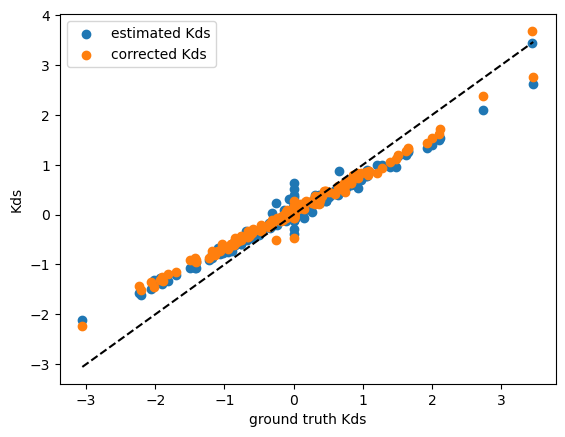

In [36]:
#plot ground truth vs estimated and correcceted Kds
plt.scatter(ground_truth, b, label='estimated Kds')
plt.scatter(ground_truth, corrected_Kds, label='corrected Kds')
plt.xlabel('ground truth Kds')
plt.ylabel('Kds')
plt.legend()
# add 1:1 line
plt.plot([np.min(ground_truth), np.max(ground_truth)], [np.min(ground_truth), np.max(ground_truth)], 'k--')
plt.show()